Some data read applications - already provided
https://github.com/automl/LCBench/blob/master/notebooks/Task%20A.ipynb

The current version provides 2000 configurations, each evaluated on 35 datasets over 50 epochs. Logs include for each epoch:

Training, test and validation losses

*   Training, test and validation accuracy
*   Global gradient statistics (max, mean, median, norm, std, q10, q25, q75, q90)


*   Training, test and validation balanced accuracy

*   Layer-wise gradient statistics (max, mean, median, norm, std, q10, q25, q75, q90)
*   Learning rate


*   Runtime


And additionally:

Configuration (architecture, hyperparameters)


*   Number of model parameters
*   Dataset statistics (number of classes, instances and features)


> The data was created using Auto-PyTorch. All runs feature funnel-shaped MLP nets and use SGD with cosine annealing without restarts. Overall, 7 parameters were sampled at random (4 float, 3 integer). These are:

* Batch size: [16, 512], on log-scale
* Learning rate: [1e-4, 1e-1], on log-scale
* Momentum: [0.1, 0.99]
* Weight decay: [1e-5, 1e-1]
* Number of layers: [1, 5]
* Maximum number of units per layer: [64, 1024], on log-scale
* Dropout: [0.0, 1.0]









In [0]:
# copy the API part as is
import os as os
import numpy as np
import json
import pickle
import gzip

import matplotlib.pyplot as plt


class Benchmark():
    """API for TabularBench."""
    
    def __init__(self, data_dir, cache=False, cache_dir="cached/"):
        """Initialize dataset (will take a few seconds-minutes).
        
        Keyword arguments:
        bench_data -- str, the raw benchmark data directory
        """
        if not os.path.isfile(data_dir) or not data_dir.endswith(".json"):
            raise ValueError("Please specify path to the bench json file.")
            
        self.data_dir = data_dir
        self.cache_dir = cache_dir
        self.cache = cache
        
        print("==> Loading data...")
        self.data = self._read_data(data_dir)
        self.dataset_names = list(self.data.keys())
        print("==> Done.")
        
    def query(self, dataset_name, tag, config_id):
        """Query a run.
        
        Keyword arguments:
        dataset_name -- str, the name of the dataset in the benchmark
        tag -- str, the tag you want to query
        config_id -- int, an identifier for which run you want to query, if too large will query the last run
        """
        config_id = str(config_id)
        if dataset_name not in self.dataset_names:
            raise ValueError("Dataset name not found.")
        
        if config_id not in self.data[dataset_name].keys():
            raise ValueError("Config nr %s not found for dataset %s." % (config_id, dataset_name))
            
        if tag in self.data[dataset_name][config_id]["log"].keys():
            return self.data[dataset_name][config_id]["log"][tag]
        
        if tag in self.data[dataset_name][config_id]["results"].keys():
            return self.data[dataset_name][config_id]["results"][tag]
        
        if tag in self.data[dataset_name][config_id]["config"].keys():
            return self.data[dataset_name][config_id]["config"][tag]
        
        if tag == "config":
            return self.data[dataset_name][config_id]["config"]
            
        raise ValueError("Tag %s not found for config %s for dataset %s" % (tag, config_id, dataset_name))
        
    def query_best(self, dataset_name, tag, criterion, position=0):
        """Query the n-th best run. "Best" here means achieving the largest value at any epoch/step,
        
        Keyword arguments:
        dataset_name -- str, the name of the dataset in the benchmark
        tag -- str, the tag you want to query
        criterion -- str, the tag you want to use for the ranking
        position -- int, an identifier for which position in the ranking you want to query
        """
        performances = []
        for config_id in self.data[dataset_name].keys():
            performances.append((config_id, max(self.query(dataset_name, criterion, config_id))))

        performances.sort(key=lambda x: x[1]*1000, reverse=True)
        desired_position = performances[position][0]

        return self.query(dataset_name, tag, desired_position)
        
    def get_queriable_tags(self, dataset_name=None, config_id=None):
        """Returns a list of all queriable tags"""
        if dataset_name is None or config_id is None:
            dataset_name = list(self.data.keys())[0]
            config_id = list(self.data[dataset_name].keys())[0]
        else:
            config_id = str(config_id)
        log_tags = list(self.data[dataset_name][config_id]["log"].keys())
        result_tags = list(self.data[dataset_name][config_id]["results"].keys())
        config_tags = list(self.data[dataset_name][config_id]["config"].keys())
        additional = ["config"]
        return log_tags+result_tags+config_tags+additional
    
    def get_dataset_names(self):
        """Returns a list of all availabe dataset names like defined on openml"""
        return self.dataset_names
    
    def get_openml_task_ids(self):
        """Returns a list of openml task ids"""
        task_ids = []
        for dataset_name in self.dataset_names:
            task_ids.append(self.query(dataset_name, "OpenML_task_id", 1))
        return task_ids
    
    def get_number_of_configs(self, dataset_name):
        """Returns the number of configurations for a dataset"""
        if dataset_name not in self.dataset_names:
            raise ValueError("Dataset name not found.")
        return len(self.data[dataset_name].keys())
    
    def get_config(self, dataset_name, config_id):
        """Returns the configuration of a run specified by dataset name and config id"""
        if dataset_name not in self.dataset_names:
            raise ValueError("Dataset name not found.")
        return self.data[dataset_name][config_id]["config"]
        
    def plot_by_name(self, dataset_names, x_col, y_col, n_configs=10, show_best=False, xscale='linear', yscale='linear', criterion=None):
        """Plot multiple datasets and multiple runs.
        
        Keyword arguments:
        dataset_names -- list
        x_col -- str, tag to plot on x-axis
        y_col -- str, tag to plot on y-axis
        n_configs -- int, number of configs to plot for each dataset
        show_best -- bool, weather to show the n_configs best (according to query_best())
        xscale -- str, set xscale, options as in matplotlib: "linear", "log", "symlog", "logit", ...
        yscale -- str, set yscale, options as in matplotlib: "linear", "log", "symlog", "logit", ...
        criterion -- str, tag used as criterion for query_best()    
        """
        if isinstance(dataset_names, str):
            dataset_names = [dataset_names]
        if not isinstance(dataset_names, (list, np.ndarray)):
            raise ValueError("Please specify a dataset name or a list list of dataset names.")
    
        n_rows = len(dataset_names)
        fig, axes = plt.subplots(n_rows, 1, sharex=False, sharey=False, figsize=(10,7*n_rows))
    
        if criterion is None:
            criterion = y_col
            
        loop_arg = enumerate(axes.flatten()) if len(dataset_names)>1 else [(0,axes)]
    
        for ind_ax, ax in loop_arg:
            for ind in range(n_configs):
                try:
                    if ind==0:
                        instances = int(self.query(dataset_names[ind_ax], "instances", 0))
                        classes = int(self.query(dataset_names[ind_ax], "classes", 0))
                        features = int(self.query(dataset_names[ind_ax], "features", 0))
            
                    if show_best:
                        x = self.query_best(dataset_names[ind_ax], x_col, criterion, ind)
                        y = self.query_best(dataset_names[ind_ax], y_col, criterion, ind)
                    else:
                        x = self.query(dataset_names[ind_ax], x_col, ind+1)
                        y = self.query(dataset_names[ind_ax], y_col, ind+1)
                        
                    ax.plot(x, y, 'p-')
                    ax.set_xscale(xscale)
                    ax.set_yscale(yscale)
                    ax.set(xlabel="step", ylabel=y_col)
                    title_str = ", ".join([dataset_names[ind_ax],
                                          "features: " + str(features),
                                          "classes: " + str(classes),
                                          "instances: " + str(instances)])
                    ax.title.set_text(title_str)
                except ValueError:
                    print("Run %i not found for dataset %s" %(ind, dataset_names[ind_ax]))
                except Exception as e:
                    raise e
                    
    def _cache_data(self, data, cache_file):
        os.makedirs(self.cache_dir, exist_ok=True)
        with gzip.open(cache_file, 'wb') as f:
            pickle.dump(data, f)
    
    def _read_cached_data(self, cache_file):
        with gzip.open(cache_file, 'rb') as f:
            data = pickle.load(f)
        return data
                    
    def _read_file_string(self, path):
        """Reads a large json string from path. Python file handler has issues with large files so it has to be chunked."""
        # Shoutout to https://stackoverflow.com/questions/48122798/oserror-errno-22-invalid-argument-when-reading-a-huge-file
        file_str = ''
        with open(path, 'r') as f:
            while True:
                block = f.read(64 * (1 << 20)) # Read 64 MB at a time
                if not block:                  # Reached EOF
                    break
                file_str += block
        return file_str
        
    def _read_data(self, path):
        """Reads cached data if available. If not, reads json and caches the data as .pkl.gz"""
        cache_file = os.path.join(self.cache_dir, os.path.basename(self.data_dir).replace(".json", ".pkl.gz"))
        if os.path.exists(cache_file) and self.cache:
            print("==> Found cached data, loading...")
            data = self._read_cached_data(cache_file)
        else:
            print("==> No cached data found or cache set to False.")
            print("==> Reading json data...")
            data = json.loads(self._read_file_string(path))
            if self.cache:
                print("==> Caching data...")
                self._cache_data(data, cache_file)
        return data


In [0]:

# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data(bench=None):
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    


Utils by Sven - some data preprocessing and normalizing


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import numpy as np
import typing

def check_cuda():
    """Returns device"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def tt(ndarray:np.ndarray):
  if torch.cuda.is_available():
    return Variable(torch.from_numpy(ndarray).float().cuda(), requires_grad=True)
  return Variable(torch.from_numpy(ndarray).float(), requires_grad=True)

def make_torch_dataset(data:np.ndarray, targets:np.ndarray)->torch.utils.data.dataset:
    return TensorDataset(*data,targets)

def make_torch_dataloader(torch_dataset:torch.utils.data.dataset,batch_size)->torch.utils.data.dataset:
    return DataLoader(dataset=torch_dataset,batch_size=batch_size)

def remove_config_entry(configs:np.ndarray,keys=['activation',
                                                 'cosine_annealing_T_max',
                                                 'cosine_annealing_eta_min',
                                                 'imputation_strategy',
                                                 'learning_rate_scheduler',
                                                 'loss',
                                                 'mlp_shape',
                                                 'normalization_strategy',
                                                 'optimizer',
                                                 'network'])->np.ndarray:
    for c in configs:
        for key in keys:
            if key in c.keys():
                del c[key]
    return configs

def get_first_n_epochs(temporal_data:np.ndarray,n=10)->np.ndarray:
    return temporal_data[:,:n]

def get_last_n_epochs(temporal_data:np.ndarray,n=41)->np.ndarray:
    return temporal_data[:,-n:]

def extract_from_data(data:np.ndarray, key)->np.ndarray:
    output = []
    for d in data:
        output.append(d[key])
    return np.array(output)

def normalize_configs(configs:np.ndarray)->np.ndarray:
    output = []
    for config in configs:
        #config['activation'] = 0 if "relu" else 1
        config['batch_size'] /= 511
        #config['cosine_annealing_T_max'] = 1
        #config['cosine_annealing_eta_min'] = config['cosine_annealing_eta_min']
        #config['imputation_strategy'] = 0
        config['learning_rate'] = config['learning_rate']
        #config['learning_rate_scheduler'] = 0
        #config['loss'] = 0
        config['max_dropout'] = config['max_dropout']
        config['max_units'] /= 1024
        #config['mlp_shape'] = 0
        config['momentum'] = config['momentum']
        #config['normalization_strategy'] = 0
        config['num_layers'] /= 4
        #config['optimizer'] = 0
        config['weight_decay'] = config['weight_decay']

        list_values = [float(v) for v in config.values()]
        output.append(list_values)

    return np.array(output)

def normalize_temporal_data(temporal_data:np.ndarray,
                            normalization_factor)->np.ndarray:
    return temporal_data/normalization_factor

def prep_data(data:np.ndarray, target_data:np.ndarray, batch_size,
              temporal_keys=['Train/val_accuracy'], first_n_epochs=10,
              normalization_factor_temporal_data=[1],
              one_shot=False)->torch.utils.data.dataset:

    assert batch_size > 0
    assert first_n_epochs > 0
    assert len(temporal_keys) == len(normalization_factor_temporal_data)
    assert all([normalization_factor > 0 for normalization_factor in normalization_factor_temporal_data])

    configs = extract_from_data(data,"config")
    configs = remove_config_entry(configs)
    configs = normalize_configs(configs)
    configs = torch.FloatTensor(configs)

    data_list = []
    for k, normalization_factor in zip(temporal_keys, normalization_factor_temporal_data):
        d = extract_from_data(data,key=k)
        d = get_first_n_epochs(d, first_n_epochs)
        d = normalize_temporal_data(d, normalization_factor)
        d = torch.FloatTensor(d)
        data_list.append(d)

    data_list.append(configs)

    if one_shot:
        val_acc = extract_from_data(data, key='Train/val_accuracy')
        target_data = val_acc

    target_data = torch.FloatTensor(target_data)
    dataset = make_torch_dataset(data_list,target_data)
    data_loader = make_torch_dataloader(dataset,batch_size)
    return data_loader

In [0]:
if __name__ == '__main__':

  data_path = '/content/drive/My Drive/ColabWorks/DL_project/DATA/fashion_mnist.json'
  data_root = Benchmark(data_dir=data_path)

  train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data(data_root)

  print("Train:", len(train_data))
  print("Validation:", len(val_data))
  print("Test:", len(test_data))

  
  # we have 1000 configurations, each having 50 epochs
  print(train_data[0])
  print(train_targets)
  print(test_data[0].keys())

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.
Train: 1000
Validation: 500
Test: 500
{'config': {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}, 'Train/loss': [2.314540386199951, 1.9220430850982664, 1.201086401939392, 0.8936665654182434, 0.7658511996269226, 0.6972703337669373, 0.6540151834487915, 0.622721254825592, 0.5984394550323486, 0.5788958072662354, 0.5626271367073059, 0.5487494468688965, 0.5370408892631531, 0.52688068151474, 0.5176886320114136, 0.5100060701370239, 0.503

In [0]:
# get the data for config 0 across first 10 epochs
config_0 = train_data[0]
config_0_keys = config_0.keys()

# each config has a static part which is the network config parameters and dynamic parts - loss, accuracy, cross_entropy, test_result, gradient_max etc
print("============ static =============")
for stat_keys in config_0["config"].keys():
  print(stat_keys)

for key in train_data[0].keys():
  print(key)

for key in val_data[0].keys():
  print(key)

for key in test_data[0].keys():
  print(key)
  # print("number of values in {0} = {1}".format(key, len(train_data[0][key])))

# trainig dataset structure - [1000, feature, values across 50 epochs]
# features to use batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

============ static =============
batch_size
imputation_strategy
learning_rate_scheduler
loss
network
max_dropout
normalization_strategy
optimizer
cosine_annealing_T_max
cosine_annealing_eta_min
activation
max_units
mlp_shape
num_layers
learning_rate
momentum
weight_decay
config
Train/loss
Train/train_accuracy
Train/val_accuracy
Train/train_cross_entropy
Train/val_cross_entropy
Train/train_balanced_accuracy
Train/val_balanced_accuracy
Train/test_result
Train/test_cross_entropy
Train/test_balanced_accuracy
Train/gradient_max
Train/gradient_mean
Train/gradient_median
Train/gradient_std
Train/gradient_q10
Train/gradient_q25
Train/gradient_q75
Train/gradient_q90
Train/layer_wise_gradient_max_layer_0
Train/layer_wise_gradient_max_layer_1
Train/layer_wise_gradient_max_layer_2
Train/layer_wise_gradient_mean_layer_0
Train/layer_wise_gradient_mean_layer_1
Train/layer_wise_gradient_mean_layer_2
Train/layer_wise_gradient_median_layer_0
Train/layer_wise_gradient_median_layer_1
Train/layer_wise_gra

In [0]:
#------ old data prep code --------#
"""
  #-------------------------- training data preparation ----------------------------------------------------------------------------------#

  # normalization : https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0


  # let's build the input data, each column is a feature, each row is an epoch, 10 rows = 10 epochs, 10 columns = 10 features
  # features : [batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay] -> static config params
  # featuers : [Train/loss, Train/train_accuracy, Train/val_accuracy, Train/gradient_std]
  for index, data in enumerate(train_data):
    
    # col 0 is batch_size
    batch_size = np.full((10, 1), data["config"]["batch_size"])  # parameters from config are same for all 10 epochs
    train_data_X[index, :, 0] = batch_size.T
    feat_min = np.min(train_data_X[index, :, 0])  # get feature min
    feat_max = np.max(train_data_X[index, :, 0])  # get feature max
    train_data_X[index, :, 0] = (train_data_X[index, :, 0] - feat_min) / (feat_max - feat_min) + 0.00000001
    
    # col1 is max_dropout
    max_dropout = np.full((10, 1), data["config"]["max_dropout"])
    train_data_X[index, :, 1] = max_dropout.T
    feat_min = np.min(train_data_X[index, :, 1])  # get feature min
    feat_max = np.max(train_data_X[index, :, 1])  # get feature max
    train_data_X[index, :, 1] = (train_data_X[index, :, 1] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 2 is max_units
    max_units = np.full((10, 1), data["config"]["max_units"])
    train_data_X[index, :, 2] = max_units.T
    feat_min = np.min(train_data_X[index, :, 2])  # get feature min
    feat_max = np.max(train_data_X[index, :, 2])  # get feature max
    train_data_X[index, :, 2] = (train_data_X[index, :, 2] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 3 is num_layers
    num_layers = np.full((10, 1), data["config"]["num_layers"])
    train_data_X[index, :, 3] = num_layers.T
    feat_min = np.min(train_data_X[index, :, 3])  # get feature min
    feat_max = np.max(train_data_X[index, :, 3])  # get feature max
    train_data_X[index, :, 3] = (train_data_X[index, :, 3] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 4 is learning_rate
    learning_rate = np.full((10, 1), data["config"]["learning_rate"])
    train_data_X[index, :, 4] = learning_rate.T
    feat_min = np.min(train_data_X[index, :, 4])  # get feature min
    feat_max = np.max(train_data_X[index, :, 4])  # get feature max
    train_data_X[index, :, 5] = (train_data_X[index, :, 4] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 5 is momentum
    momentum = np.full((10, 1), data["config"]["momentum"])
    train_data_X[index, :, 5] = momentum.T
    feat_min = np.min(train_data_X[index, :, 5])  # get feature min
    feat_max = np.max(train_data_X[index, :, 5])  # get feature max
    train_data_X[index, :, 5] = (train_data_X[index, :, 5] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 6 is weight_decay
    weight_decay = np.full((10, 1), data["config"]["weight_decay"])
    train_data_X[index, :, 6] = weight_decay.T
    feat_min = np.min(train_data_X[index, :, 6])  # get feature min
    feat_max = np.max(train_data_X[index, :, 6])  # get feature max
    train_data_X[index, :, 6] = (train_data_X[index, :, 6] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col7 = Train/loss
    train_loss = np.asarray(data["Train/loss"][0:10])
    train_data_X[index, :, 7] = train_loss.T
    feat_min = np.min(train_data_X[index, :, 7])  # get feature min
    feat_max = np.max(train_data_X[index, :, 7])  # get feature max
    train_data_X[index, :, 7] = (train_data_X[index, :, 7] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 8 = train_accuracy
    train_accuracy = np.asarray(data["Train/train_accuracy"][0:10])
    train_data_X[index, :, 8] = train_accuracy.T
    feat_min = np.min(train_data_X[index, :, 8])  # get feature min
    feat_max = np.max(train_data_X[index, :, 8])  # get feature max
    train_data_X[index, :, 8] = (train_data_X[index, :, 8] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # col 9 = Train/val_accuracy
    val_acc = np.asarray(data["Train/val_accuracy"][0:10])
    train_data_X[index, :, 9] = val_acc.T
    feat_min = np.min(train_data_X[index, :, 9])  # get feature min
    feat_max = np.max(train_data_X[index, :, 9])  # get feature max
    train_data_X[index, :, 9] = (train_data_X[index, :, 9] - feat_min) / (feat_max - feat_min)+ 0.00000001

    # get the label for this config, it is the Train/val_accuracy for the 51st epoch of this config
    train_data_Y[index] = train_targets[index]
    

    # Y = data["Train/val_accuracy"][50] # same as the above statement

  # normalize the targets
  feat_min = np.min(train_data_Y)  # get feature min
  feat_max = np.max(train_data_Y)  # get feature max
  train_data_Y = (train_data_Y - feat_min) / (feat_max - feat_min)+ 0.00000001


  # do column wise/ feature wise normalization


  # add a channel dimension
  # np.expand_dims(train_data_X, axis=-1)  
  # print a summary
  print("========= training data summary =========")
  print("train_X shape : ", train_data_X.shape)
  print("Unique values in train_X : ", np.unique(train_data_X))
  print("train_Y_shape : ", train_data_Y.shape)


  #---------------------------------------------------------------------------------------------------------------------------------------------#

  # -------------- validation data preparation -------------------------------------------------------------------------------------------------#
  validation_data_X = np.zeros((500, 10, 10))
  validation_data_Y = np.zeros((500, 1))

  for index, data in enumerate(val_data):
    # col 0 is batch_size
    batch_size = np.full((10, 1), data["config"]["batch_size"])  # parameters from config are same for all 10 epochs
    validation_data_X[index, :, 0] = batch_size.T
    validation_data_X[index, :, 0] /= np.max(validation_data_X[index, :, 0])
    
    # col1 is max_dropout
    max_dropout = np.full((10, 1), data["config"]["max_dropout"])
    validation_data_X[index, :, 1] = max_dropout.T
    validation_data_X[index, :, 1] /= np.max(validation_data_X[index, :, 1])

    # col 2 is max_units
    max_units = np.full((10, 1), data["config"]["max_units"])
    validation_data_X[index, :, 2] = max_units.T
    validation_data_X[index, :, 2] /= np.max(validation_data_X[index, :, 2])

    # col 3 is num_layers
    num_layers = np.full((10, 1), data["config"]["num_layers"])
    validation_data_X[index, :, 3] = num_layers.T
    validation_data_X[index, :, 3] /= np.max(validation_data_X[index, :, 3])

    # col 4 is learning_rate
    learning_rate = np.full((10, 1), data["config"]["learning_rate"])
    validation_data_X[index, :, 4] = learning_rate.T
    validation_data_X[index, :, 4] /= np.max(validation_data_X[index, :, 4])

    # col 5 is momentum
    momentum = np.full((10, 1), data["config"]["momentum"])
    validation_data_X[index, :, 5] = momentum.T
    validation_data_X[index, :, 5] /= np.max(validation_data_X[index, :, 5])

    # col 6 is weight_decay
    weight_decay = np.full((10, 1), data["config"]["weight_decay"])
    validation_data_X[index, :, 6] = weight_decay.T
    validation_data_X[index, :, 6] /= np.max(validation_data_X[index, :, 6])

    # col7 = Train/loss
    train_loss = np.asarray(data["Train/loss"][0:10])
    validation_data_X[index, :, 7] = train_loss.T
    validation_data_X[index, :, 7] /= np.max(validation_data_X[index, :, 7])

    # col 8 = train_accuracy
    train_accuracy = np.asarray(data["Train/train_accuracy"][0:10])
    validation_data_X[index, :, 8] = train_accuracy.T
    validation_data_X[index, :, 8] /= np.max(validation_data_X[index, :, 8])

    # col 9 = Train/val_accuracy
    val_acc = np.asarray(data["Train/val_accuracy"][0:10])
    validation_data_X[index, :, 9] = val_acc.T
    validation_data_X[index, :, 9] /= np.max(validation_data_X[index, :, 9])

    # get the label for this config, it is the Train/val_accuracy for the 51st epoch of this config
    validation_data_Y[index] = val_targets[index]

  validation_data_Y /= np.max(validation_data_Y)


  return train_data_X, train_data_Y, validation_data_X, validation_data_Y

  


# train_data_Y = train_data[:]["Train/val_accuracy"][-1]
"""

'\n  #-------------------------- training data preparation ----------------------------------------------------------------------------------#\n\n  # normalization : https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0\n\n\n  # let\'s build the input data, each column is a feature, each row is an epoch, 10 rows = 10 epochs, 10 columns = 10 features\n  # features : [batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay] -> static config params\n  # featuers : [Train/loss, Train/train_accuracy, Train/val_accuracy, Train/gradient_std]\n  for index, data in enumerate(train_data):\n    \n    # col 0 is batch_size\n    batch_size = np.full((10, 1), data["config"]["batch_size"])  # parameters from config are same for all 10 epochs\n    train_data_X[index, :, 0] = batch_size.T\n    feat_min = np.min(train_data_X[index, :, 0])  # get feature min\n    feat_max = np.max(train_data_X[index, :, 0])  # get feature max\n    trai

In [0]:

def get_data():
  """
  Function returns training and validation data and labels normalized [0-1]
  """

  # lets see how the targets look likes
  # print(type(train_targets))
  # print(train_targets)
  # print(len(train_targets))

  # we have to predict the validation accuracy
  # in the data, for each config, we have 50 epochs, each epoch has a validation accuracy
  # use only 10 epochs for training and predict the 51st epoch val/accuracy

  # print(config_0["Train/val_accuracy"])
  # print(len(config_0["Train/val_accuracy"]))


  # ------------ new code - just make column vectors for each config, so (1000, 10, 1) is the shape of training data ---------------#
  train_data_new_X = np.zeros((1000, 14, 1))
  train_data_new_Y = np.zeros((1000, 1))

  val_data_X = np.zeros((500, 14, 1))
  val_data_Y = np.zeros((500, 1))

  test_data_X = np.zeros((500, 14, 1))
  test_data_Y = np.zeros((500, 1))

  for index, data in enumerate(train_data):
    # print(index, data)
    train_data_new_X[index, 0] = data["config"]["batch_size"]  # config params are single value scalars
    train_data_new_X[index, 1] = data["config"]["max_dropout"]
    train_data_new_X[index, 2] = data["config"]["max_units"]
    train_data_new_X[index, 3] = data["config"]["num_layers"]
    train_data_new_X[index, 4] = data["config"]["learning_rate"]
    train_data_new_X[index, 5] = data["config"]["momentum"]
    train_data_new_X[index, 6] = data["config"]["weight_decay"]

    #------- dynamic params -----------#
    train_data_new_X[index, 7] = np.sum(np.asarray(data["Train/loss"][0:10])) / 10  # these we use only first 10 epochs, average loss
    train_data_new_X[index, 8] = np.sum(np.asarray(data["Train/train_accuracy"][0:10])) / 10 # average accuracy across 10 epochs
    train_data_new_X[index, 9] = np.sum(np.asarray(data["Train/val_accuracy"][0:10])) / 10 # average val_acc across 10 epochs
    train_data_new_X[index, 10] = np.sum(np.asarray(data["Train/train_cross_entropy"][0:10])) / 10
    train_data_new_X[index, 11] = np.sum(np.asarray(data["Train/val_cross_entropy"][0:10])) / 10
    train_data_new_X[index, 12] = np.sum(np.asarray(data["Train/gradient_mean"][0:10])) / 10
    train_data_new_X[index, 13] = np.sum(np.asarray(data["Train/lr"][0:10])) / 10


    train_data_new_Y[index] = train_targets[index]  # validation accuracy for 51st epoch, for each

    # print("target for config 0 : {0}, from dataset : {1}".format(train_data_new_Y[index], data["Train/val_accuracy"][50])) 

    # print(train_data_new_X[0])


  # normalize each feature across all batches, so each feature is in range [0-1]
  for feat_index in range(14):
    feat_min = np.min(train_data_new_X[:, feat_index, 0])  # min of feature 0 across all batches
    feat_max = np.max(train_data_new_X[:, feat_index, 0]) 
    # print(feat_min, feat_max)

    # normalize input features
    train_data_new_X[:, feat_index, 0] = (train_data_new_X[:, feat_index, 0] - feat_min) / (feat_max - feat_min)
    # print(train_data_new_X[:, feat_index], train_data_new_X[:, feat_index].shape)

  # normalize labels
  feat_min = np.min(train_data_new_Y)
  feat_max = np.max(train_data_new_Y)

  train_data_new_Y = (train_data_new_Y - feat_min) / (feat_max - feat_min)  # normalize labels

  

  #------- for validation set --------------#
  
  for index, data in enumerate(val_data):
    # print(index, data)
    val_data_X[index, 0] = data["config"]["batch_size"]  # config params are single value scalars
    val_data_X[index, 1] = data["config"]["max_dropout"]
    val_data_X[index, 2] = data["config"]["max_units"]
    val_data_X[index, 3] = data["config"]["num_layers"]
    val_data_X[index, 4] = data["config"]["learning_rate"]
    val_data_X[index, 5] = data["config"]["momentum"]
    val_data_X[index, 6] = data["config"]["weight_decay"]

    #------- dynamic params -----------#
    # val_data_X[index, 7] = np.sum(np.asarray(data["Train/loss"][0:10])) / 10  # these we use only first 10 epochs, average loss
    # val_data_X[index, 8] = np.sum(np.asarray(data["Train/train_accuracy"][0:10])) / 10 # average accuracy across 10 epochs
    # val_data_X[index, 9] = np.sum(np.asarray(data["Train/val_accuracy"][0:10])) / 10 # average val_acc across 10 epochs

    val_data_X[index, 7] = np.sum(np.asarray(data["Train/loss"][0:10])) / 10  # these we use only first 10 epochs, average loss
    val_data_X[index, 8] = np.sum(np.asarray(data["Train/train_accuracy"][0:10])) / 10 # average accuracy across 10 epochs
    val_data_X[index, 9] = np.sum(np.asarray(data["Train/val_accuracy"][0:10])) / 10 # average val_acc across 10 epochs
    val_data_X[index, 10] = np.sum(np.asarray(data["Train/train_cross_entropy"][0:10])) / 10
    val_data_X[index, 11] = np.sum(np.asarray(data["Train/val_cross_entropy"][0:10])) / 10
    val_data_X[index, 12] = np.sum(np.asarray(data["Train/gradient_mean"][0:10])) / 10
    val_data_X[index, 13] = np.sum(np.asarray(data["Train/lr"][0:10])) / 10

    val_data_Y[index] = val_targets[index]  # validation accuracy for 51st epoch, for each 

  
  
  # normalize each feature across all batches, so each feature is in range [0-1]
  for feat_index in range(14):
    feat_min = np.min(val_data_X[:, feat_index, 0])  # min of feature 0 across all batches
    feat_max = np.max(val_data_X[:, feat_index, 0]) 
    print(feat_min, feat_max)

    # normalize input features
    val_data_X[:, feat_index, 0] = (val_data_X[:, feat_index, 0] - feat_min) / (feat_max - feat_min)
    # print(val_data_X[:, feat_index], val_data_X[:, feat_index].shape)

  # normalize labels
  feat_min = np.min(val_data_Y)
  feat_max = np.max(val_data_Y)

  val_data_Y = (val_data_Y - feat_min) / (feat_max - feat_min) # normalize labels


  #------- for test set --------------#
  
  for index, data in enumerate(test_data):
    # print(index, data)
    test_data_X[index, 0] = data["config"]["batch_size"]  # config params are single value scalars
    test_data_X[index, 1] = data["config"]["max_dropout"]
    test_data_X[index, 2] = data["config"]["max_units"]
    test_data_X[index, 3] = data["config"]["num_layers"]
    test_data_X[index, 4] = data["config"]["learning_rate"]
    test_data_X[index, 5] = data["config"]["momentum"]
    test_data_X[index, 6] = data["config"]["weight_decay"]

    #------- dynamic params -----------#
    test_data_X[index, 7] = np.sum(np.asarray(data["Train/loss"][0:10])) / 10  # these we use only first 10 epochs, average loss
    test_data_X[index, 8] = np.sum(np.asarray(data["Train/train_accuracy"][0:10])) / 10 # average accuracy across 10 epochs
    test_data_X[index, 9] = np.sum(np.asarray(data["Train/val_accuracy"][0:10])) / 10 # average val_acc across 10 epochs
    test_data_X[index, 10] = np.sum(np.asarray(data["Train/train_cross_entropy"][0:10])) / 10
    test_data_X[index, 11] = np.sum(np.asarray(data["Train/val_cross_entropy"][0:10])) / 10
    test_data_X[index, 12] = np.sum(np.asarray(data["Train/gradient_mean"][0:10])) / 10
    test_data_X[index, 13] = np.sum(np.asarray(data["Train/lr"][0:10])) / 10


    test_data_Y[index] = test_targets[index]  # validation accuracy for 51st epoch, for each 
    
  
  # normalize each feature across all batches, so each feature is in range [0-1]
  for feat_index in range(14):
    feat_min = np.min(test_data_X[:, feat_index, 0])  # min of feature 0 across all batches
    feat_max = np.max(test_data_X[:, feat_index, 0]) 
    print(feat_min, feat_max)

    # normalize input features
    test_data_X[:, feat_index, 0] = (test_data_X[:, feat_index, 0] - feat_min) / (feat_max - feat_min)
    # print(val_data_X[:, feat_index], val_data_X[:, feat_index].shape)

  # normalize labels
  feat_min = np.min(test_data_Y)
  feat_max = np.max(test_data_Y)

  test_data_Y = (test_data_Y - feat_min) / (feat_max - feat_min) # normalize labels


  # print(val_data_Y)
  

  return train_data_new_X, train_data_new_Y, val_data_X, val_data_Y, test_data_X, test_data_Y










Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 14, 1)             0         
_________________________________________________________________
dense_309 (Dense)            (None, 14, 16)            32        
_________________________________________________________________
dropout_131 (Dropout)        (None, 14, 16)            0         
_________________________________________________________________
dense_310 (Dense)            (None, 14, 16)            272       
_________________________________________________________________
dropout_132 (Dropout)        (None, 14, 16)            0         
_________________________________________________________________
dense_311 (Dense)            (None, 14, 16)            272       
_________________________________________________________________
flatten_82 (Flatten)         (None, 224)               0  

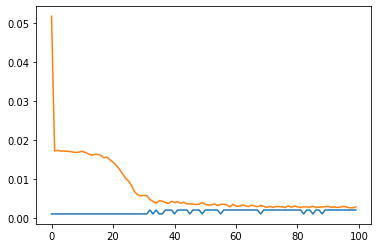

In [0]:
# build a MLP here
import tensorflow as tf
import keras 
from keras.activations import relu, sigmoid, tanh
from keras.layers import Conv2D, Conv1D, Dense, Flatten, Input, Dropout
from keras.optimizers import Adam,SGD
from keras.models import Model

def build_model(input_shape=(1000, 10, 1)):
  """
  Function builds a keras model
  """

  # optim = SGD(lr=0.001, momentum=0.9)
  optim = Adam()
  inputs = Input(shape=(14, 1))

  dense1_out = Dense(16, activation='sigmoid', kernel_initializer='he_uniform')(inputs)
  drop1_out = Dropout(rate=0.3)(dense1_out)
  dense2_out = Dense(16, activation='sigmoid', kernel_initializer='he_uniform')(drop1_out)
  drop2_out = Dropout(rate=0.2)(dense2_out)
  dense3_out = Dense(16, activation='sigmoid', kernel_initializer='he_uniform')(drop2_out)
  flat_out = Flatten()(dense3_out)
  final_out = Dense(1, activation='sigmoid')(flat_out)  # last layer, no activation

  model = Model(inputs=inputs, outputs=final_out)

  model.compile(optimizer=optim,
              loss='mean_squared_error',
              metrics=['accuracy'])
  
  model.summary()

  return model


if __name__ == '__main__':

  model = build_model()

  for layer in model.layers:
    print(layer.output.shape)

  train_X, train_Y, val_X, val_Y, test_X, test_Y = get_data()  # get the prepared data

  print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape)
  
  # debug code - match that the processed targets and targets read from the database are equal except the normalizing
  
  # for i in range(0, 10):
  #   print("processed : {0}, database : {1}".format(train_Y[i], train_targets[i]))

  # # removing normalization
  # print("without norm")
  # for i in range(0, 10):
  #   print("processed : {0}, database : {1}".format(train_Y[i] * np.max(train_targets), train_targets[i]))
  """

  """
  history = model.fit(x=train_X, y=train_Y, batch_size=16, epochs=100, verbose=1, validation_data=(val_X, val_Y))
  
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])

  model.save("/content/drive/My Drive/ColabWorks/DL_project/LC_predictor.h5")

  res = model.predict(test_X)

  print(res.shape, test_Y.shape)

  #----------- predictions ------------#
  for index, data in enumerate(test_Y):
    print("test target : {0}, prediction : {1}, error(%) : {2}".format(data, res[index], abs(res[index] - data)*100))


  avg_err = (np.sum(res - test_Y)/1000)*100
  print("average error over 1000 predictions : ", avg_err)
  print("maximum error over 1000 predictions : ", np.max(res - test_Y))
  print("minimum error over 1000 predictions : ", np.min(res - test_Y))


  # res = model.evaluate(x=test_X, y=test_Y)
  # print(res)

  
  


In [0]:
err = abs(res - test_Y)
# print(err)
# print(np.maximum(err))
# print(np.minimum(err))

print("max %: ", np.max(err) * 100)
print("min %: ",  np.min(err) * 100)

print("avg error : ", (np.sum(err)/1000)*100)

max %:  28.939425945281982
min %:  0.0005308431500705701
avg error :  1.2785721668780932
